In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install openpyxl


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [188]:
file_path = '/mnt/c/Users/tsimk/Downloads/research/H08/additional_data/GPWv4/gpw-v4-country-level-summary-rev11.xlsx'
df = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, header=1)
result = df[['Country or Territory Name', 'Highest Admin Level Used', 'Number of Units']]
# 結果を表示
result.head(5)

,Country or Territory Name,Highest Admin Level Used,Number of Units
0,Aruba,2,55
1,Afghanistan,2,401
2,Angola,2,161
3,Anguilla,0,1
4,Åland Islands,1,16


In [189]:
text_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_third.txt'
txt_df = pd.read_csv(text_path, sep="|", header=None)
txt_df.columns = ['City Number', 'Status', 'Type', 'WUP_pop', 'Full_pop', 
                  'clustered_pop', 'Country', 'gids', 'Region', 'Latitude', 
                  'Longitude', 'City Name', 'Continent']
txt_df.head(5)

,City Number,Status,Type,WUP_pop,Full_pop,clustered_pop,Country,gids,Region,Latitude,Longitude,City Name,Continent
0,1,VALD,DOWN,36859.626,36855016.0,31821846.0,Japan,93.0,eastern asia,35.689500,139.691710,Tokyo,East Asia
1,2,VALD,FULL,21987.895,22058268.0,22058266.0,India,39.0,southern asia,28.666670,77.216670,Delhi,South Asia
2,3,VALD,DOWN,20314.309,20277882.0,18339050.0,China,33.0,eastern asia,31.222220,121.458060,Shanghai,East Asia
3,4,VALD,FULL,20136.681,20178100.0,20178102.0,Mexico,43.0,central america,19.427318,-99.141869,Ciudad de México (Mexico City),Central America
4,5,VALD,DOWN,19659.808,19608378.0,18857166.0,Brazil,34.0,south america,-23.547500,-46.636110,São Paulo,South America


In [190]:
####################################################################
# city_country_mappigは都市番号(city)をkeyに持ち
# 対応する国名リスト(countries)をvalueに持つ辞書
# countriesはGPWv4(df)のCoutry or territoy nameに準拠
### このコードは重複して複数のcountryに保存されているcity numberを整理している
####################################################################

# 国名データフレームの作成
file_path = '/mnt/c/Users/tsimk/Downloads/research/H08/additional_data/GPWv4/gpw-v4-country-level-summary-rev11.xlsx'
df = pd.read_excel(file_path, engine='openpyxl', sheet_name=1, header=1)

text_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_third.txt'
txt_df = pd.read_csv(text_path, sep="|", header=None)
txt_df.columns = ['City Number', 'Status', 'Type', 'WUP_pop', 'Full_pop', 
              'clustered_pop', 'Country', 'gids', 'Region', 'Latitude', 
              'Longitude', 'City Name', 'Continent']

# Taiwan, の特別処理用マップ
special_country_mapping = {
    "Taiwan": lambda x: "Taiwan" in x,
    "China Macao Special Administrative Region": lambda x: "Macao" in x,
    "China Hong Kong Special Administrative Region": lambda x: "Hong Kong" in x,
    "Democratic People's Republic of Korea": lambda x: "People's Republic" in x,
    "Bolivia (Plurinational State of)": lambda x: "Bolivia" in x,
    "Czech Republic": lambda x: "Czech" in x,
    "Iran (Islamic Republic of)": lambda x: "Iran" in x,
    "The former Yugoslav Republic of Macedonia": lambda x: "Macedonia" in x,
    "United Kingdom of Great Britain and Northern Ireland": lambda x: "United Kingdom" in x,
    "Venezuela (Bolivarian Republic of)": lambda x: "Venezuela" in x,
}

# 完全一致が必要な国リスト
exact_match_countries = [ "Democratic Republic of the Congo", "Congo", 
                          "Dominican Republic", 
                          "Guinea", "Guinea-Bissau", "Papua New Guinea", "Equatorial Guinea", 
                          "Mali", "Somalia", 
                          "Niger", "Nigeria", 
                          "Oman", "Romania", 
                          "Sudan", "South Sudan",
                        ]

####################################################################

# 国ごとの都市番号を取得
city_country_mapping = {}

for country in df['Country or Territory Name']:
    if country in special_country_mapping:
        # 特別条件のフィルタリング
        matched_cities = txt_df.loc[txt_df['Country'].apply(special_country_mapping[country]), 'City Number'].tolist()
    elif country in exact_match_countries:
        # 完全一致が必要な国の処理
        matched_cities = txt_df.loc[txt_df['Country'] == country, 'City Number'].tolist()
    else:
        # 部分一致の処理（他の国用）
        # この時exact_match_countriesやspecial_country_mappingの国々を省く必要がある
        matched_cities = txt_df.loc[txt_df['Country'].str.contains(country, case=False, na=False), 'City Number'].tolist()
        
####################################################################

    # city numberのループ
    for city in matched_cities:
        # TaiwanまたはDominican Republicの優先条件
        if city in city_country_mapping:
            # すでに分類されている場合は特別条件を優先
            existing_countries = city_country_mapping[city]
            if "China" in existing_countries and country == "Taiwan":
                existing_countries.remove("China")  # Chinaを削除
                existing_countries.append("Taiwan")  # Taiwanを追加
                continue
            if "Taiwan" in existing_countries and country == "China":
                continue  # Taiwanに分類済みの場合、Chinaを無視
                
            if "China" in existing_countries and country == "China Macao Special Administrative Region":
                existing_countries.remove("China")  # Chinaを削除
                existing_countries.append("China Macao Special Administrative Region")
                continue
            if "China Macao Special Administrative Region" in existing_countries and country == "China":
                continue  
                
            if "China" in existing_countries and country == "China Hong Kong Special Administrative Region":
                existing_countries.remove("China")  # Chinaを削除
                existing_countries.append("China Hong Kong Special Administrative Region")
                continue
            if "China Hong Kong Special Administrative Region" in existing_countries and country == "China":
                continue  
                
            if "Republic of Korea" in existing_countries and country == "Democratic People's Republic of Korea":
                existing_countries.remove("Republic of Korea")  # Chinaを削除
                existing_countries.append("Democratic People's Republic of Korea")
                continue
            if "Democratic People's Republic of Korea" in existing_countries and country == "Republic of Korea":
                continue
                
            if "Dominica" in existing_countries and country == "Dominican Republic":
                        existing_countries.remove("Dominica")  # Dominicaの削除
                        existing_countries.append("Dominican Republic")  # Dominican Republicを追加
                        continue
            if "Dominican Republic" in existing_countries and country == "Dominica":
                continue  # Dominican Republicに分類済みの場合、Dominicaを無視
                
        city_country_mapping.setdefault(city, []).append(country)
        
####################################################################
    
# 都市番号が複数の国に対応しているものを特定
sorted_keys = sorted(city_country_mapping.keys())
over_count_cities = {city: countries for city, countries in city_country_mapping.items() if len(countries) > 1}

# 重複都市の結果を表示
if over_count_cities:
    print("Overcounted city numbers and corresponding countries:")
    for city, countries in over_count_cities.items():
        print(f"City Number {city}: {', '.join(countries)}")
else:
    print("No overcounted city numbers found.")

No overcounted city numbers found.


/tmp/ipykernel_1422/961252372.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matched_cities = txt_df.loc[txt_df['Country'].str.contains(country, case=False, na=False), 'City Number'].tolist()


In [191]:
####################################################################
# country_city_mappigは都市名(country)をkeyに持ち
# 対応する都市番号リスト(city numbers)をvalueに持つ辞書
# countriesはGPWv4のCoutry or territoy nameに準拠
### 国名に紐づく都市がない場合は'No city found'が保存されている
####################################################################
country_city_mapping = {}

for city, countries in city_country_mapping.items():
    for country in countries:
        # 国名をキーにして都市番号をリストに追加
        country_city_mapping.setdefault(country, []).append(city)

# 結果を表示
for country, cities in country_city_mapping.items():
    print(f"{country}: {cities}")

Afghanistan: [111, 1233, 1320, 1674]
Angola: [60, 862, 973, 1002, 1068, 1315, 1486, 1713, 1799]
Albania: [1157]
United Arab Emirates: [214, 494, 504, 1259, 1779]
Argentina: [12, 308, 343, 454, 550, 589, 774, 837, 964, 966, 1231, 1271, 1329, 1404, 1500, 1516, 1599]
Armenia: [416]
Australia: [80, 89, 203, 247, 359, 834, 1149, 1191, 1543, 1700, 1708]
Austria: [244]
Azerbaijan: [194, 1510, 1523]
Burundi: [856]
Belgium: [210, 447, 713, 1093, 1169]
Benin: [687, 884, 1793, 1826]
Burkina Faso: [238, 802]
Bangladesh: [11, 83, 398, 588, 903, 1139, 1152, 1181, 1382, 1415, 1855]
Bulgaria: [361, 1402, 1459]
Bahrain: [1634]
Bosnia and Herzegovina: [1392]
Belarus: [219, 978, 1316, 1354, 1442, 1525]
Bolivia (Plurinational State of): [263, 327, 453, 1780]
Brazil: [5, 16, 59, 92, 94, 100, 101, 109, 119, 140, 196, 198, 228, 254, 257, 341, 364, 373, 382, 389, 440, 503, 566, 597, 629, 689, 767, 789, 803, 836, 866, 938, 939, 999, 1100, 1125, 1126, 1217, 1235, 1247, 1250, 1254, 1293, 1327, 1361, 1383, 1411, 

In [192]:
# 都市番号が存在する場合のみカウント
total_cities = len({city for city, countries in city_country_mapping.items() if 'No city found' not in countries})
print(f"Total number of cities: {total_cities}")
# 79都市が未分類

Total number of cities: 1860


In [193]:
####################################################################
# country_admin_units
# key=country
# value=data
# data has keys of ['Highest Admin Level Used'], ['Number of Units']
# GPWv4(df)を使って国ごとのadmin level, number of unitsを収集
####################################################################

# 新しい辞書を作成して国名ごとにデータを収集
country_admin_units = {}

for country, cities in country_city_mapping.items():
    # 国名に対応する行を df から取得
    matching_rows = df[df['Country or Territory Name'] == country]
    if not matching_rows.empty:
        # 'Highest Admin Level Used' と 'Number of Units' を取得
        highest_admin_level = matching_rows['Highest Admin Level Used'].iloc[0]
        number_of_units = matching_rows['Number of Units'].iloc[0]
        
        # 辞書に保存
        country_admin_units[country] = {
            'Highest Admin Level Used': highest_admin_level,
            'Number of Units': number_of_units
        }
    else:
        print(f'No match {country}')

# 結果を表示
for country, data in country_admin_units.items():
    print(f"{country}: Highest Admin Level Used = {data['Highest Admin Level Used']}, Number of Units = {data['Number of Units']}")

Afghanistan: Highest Admin Level Used = 2, Number of Units = 401
Angola: Highest Admin Level Used = 2, Number of Units = 161
Albania: Highest Admin Level Used = 3, Number of Units = 373
United Arab Emirates: Highest Admin Level Used = 1, Number of Units = 7
Argentina: Highest Admin Level Used = 2, Number of Units = 525
Armenia: Highest Admin Level Used = 3, Number of Units = 935
Australia: Highest Admin Level Used = 5, Number of Units = 54765
Austria: Highest Admin Level Used = 4, Number of Units = 2357
Azerbaijan: Highest Admin Level Used = 1, Number of Units = 84
Burundi: Highest Admin Level Used = 2, Number of Units = 129
Belgium: Highest Admin Level Used = 4, Number of Units = 589
Benin: Highest Admin Level Used = 2, Number of Units = 77
Burkina Faso: Highest Admin Level Used = 3, Number of Units = 351
Bangladesh: Highest Admin Level Used = 3, Number of Units = 544
Bulgaria: Highest Admin Level Used = 2, Number of Units = 264
Bahrain: Highest Admin Level Used = 1, Number of Units =

In [194]:
####################################################################
# load He's accuray of each cities
# true, false, rate, region, popがそれぞれリスト形式で保存されている
####################################################################

he_text = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/he_validation.txt'
with open(he_text, 'r') as files:
    he_lines = files.readlines()
cama_new_text = f'/mnt/c/users/tsimk/downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_third.txt'
with open(cama_new_text, 'r') as files:
    new_lines = files.readlines()

true_list = []
false_list = []
rate_list = []
region_list = []
pop_list = []

for ind in range(1860):
    # cama file
    line_new = new_lines[ind]
    parts_new = line_new.split('|')
    parts_new = [item.strip() for item in parts_new]
    ovlp_flg = parts_new[1]
    dwn_flg = parts_new[2]
    region = parts_new[12]
    if ovlp_flg == 'RMVD' or dwn_flg == 'NoMK':
        true_list.append(np.nan)
        false_list.append(np.nan)
        rate_list.append(np.nan)
        region_list.append(np.nan)
        pop_list.append(np.nan)
        continue
    pop_list.append(float(parts_new[3])*10**3)

    # he file
    for line in he_lines:
        if int(line.split('|')[0].strip()) == int(ind)+1:
            line_he = line
    parts_he = line_he.split('|')
    parts_he = [item.strip() for item in parts_he]
    
    true_list.append(int(parts_he[2]))
    false_list.append(int(parts_he[3]))
    rate_list.append(int(parts_he[2])/(int(parts_he[2])+int(parts_he[3])))
    region_list.append(region)


print(len(rate_list))

1860


In [195]:
####################################################################
# データをまとめる
# city_table_data
####################################################################

# 空のリストを用意して各都市の情報を収集
city_table_data = []

for city, countries in city_country_mapping.items():
    for country in countries:
        # 国名に一致する行を df から取得
        matching_row = df[df['Country or Territory Name'] == country]
        if not matching_row.empty:
            # 行情報を取得
            administrative_level = matching_row['Highest Admin Level Used'].iloc[0]
            number_of_units = matching_row['Number of Units'].iloc[0]
            
            # 都市番号と共にリストに保存
            city_table_data.append({
                'City Number': city,
                'Administrative Level': administrative_level,
                'Number of Input Units': number_of_units,
                'precision': rate_list[int(float(city))-1],
                'region': region_list[int(float(city))-1],
                'pop': pop_list[int(float(city))-1],
            })

# データフレームに変換
city_table_df = pd.DataFrame(city_table_data)

# 結果を表示
city_table_df.head()

,City Number,Administrative Level,Number of Input Units,precision,region,pop
0,111,2,401,0.500000,Eastern Europe & Central Asia,3289005.0
1,1233,2,401,0.125000,Eastern Europe & Central Asia,383498.0
2,1320,2,401,0.250000,Eastern Europe & Central Asia,358691.0
3,1674,2,401,0.000000,Eastern Europe & Central Asia,283532.0
4,60,2,161,0.542857,Southern Africa,5300466.0


In [200]:
#####################################################
# データを変更する
# city_table_data
# 新しいラベルリスト（name_list）
######################################################

name_list = [
    'North America', 'Central America', 'South America', 'West Europe',
    'Eastern Europe', 'Northern Africa', 'Southern Africa', 'Middle East',
    'South Asia', 'Southeast Asia', 'East Asia', 'Oceania'
]

# 現在のラベルと新しいラベルを対応づけるマッピングを作成
label_mapping = {
    'Eastern Europe & Central Asia': 'Eastern Europe',
    'Southern Africa': 'Southern Africa',
    'nan': 'nan',
    'West Europe': 'West Europe',
    'Middle East': 'Middle East',
    'South America': 'South America',
    'Australia/Pacific': 'Oceania',
    'South Asia': 'South Asia',
    'North America': 'North America',
    'East Asia': 'East Asia',
    'Central America': 'Central America',
    'Northern Africa': 'Northern Africa',
    'Southeast Asia': 'Southeast Asia'
}

# ラベルを変換
city_table_df['region'] = city_table_df['region'].replace(label_mapping)

# 結果を新しいデータフレームに保存
city_table_data_revised = city_table_df.copy()
city_table_data_revised = city_table_data_revised.dropna(subset=['region'])

city_table_data_revised.head(5)

,City Number,Administrative Level,Number of Input Units,precision,region,pop
0,111,2,401,0.500000,Eastern Europe,3289005.0
1,1233,2,401,0.125000,Eastern Europe,383498.0
2,1320,2,401,0.250000,Eastern Europe,358691.0
3,1674,2,401,0.000000,Eastern Europe,283532.0
4,60,2,161,0.542857,Southern Africa,5300466.0


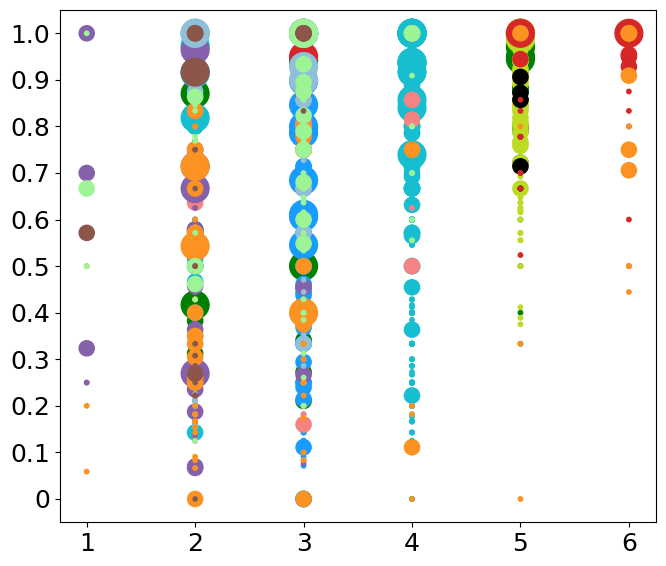

In [287]:
# カラーマッピング
colors = {
    'North America': '#bcdb22',
    'Central America': '#f58383',
    'South America': '#008000',
    'West Europe': '#d62728',
    'Eastern Europe': '#9df494',
    'Northern Africa': '#8c564b',
    'Southern Africa': '#fb9222',
    'Middle East': '#8661ab',
    'South Asia': '#199cff',
    'Southeast Asia': '#8fbfda',
    'East Asia': '#17becf',
    'Oceania': '#000000'
}

zorders = {
    'North America': 2,
    'Central America': 7,
    'South America': 1,
    'West Europe': 5,
    'Eastern Europe': 11,
    'Northern Africa': 12,
    'Southern Africa': 10,
    'Middle East': 8,
    'South Asia': 4,
    'Southeast Asia': 9,
    'East Asia': 6,
    'Oceania': 3,
}

# 散布図の作成
plt.rcParams.update({'font.size': 18}) 
plt.figure(figsize=(7, 6))

# 各 region ごとにプロット
regions = city_table_data_revised['region'].unique()  # 'region'を'Region'に修正
for region in regions:
    subset = city_table_data_revised[city_table_data_revised['region'] == region]
    pop_size = [400 if i > 5e6 else 120 if 5e6 > i > 1e6 else 10 for i in subset['pop']]
    
    plt.scatter(
        subset['Administrative Level'],
        subset['precision'],
        s=pop_size,
        color=colors.get(region, 'gray'),
        label=region,
        alpha=1,
        zorder=zorders.get(region, 1)  # 最前面に設定
    )

# 凡例の設定
#plt.legend(title='region', bbox_to_anchor=(1.05, 1), loc='upper left')
yaxis = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(yaxis, yaxis)

# グラフのレイアウト調整
plt.grid(False)
plt.tight_layout()

# グラフを表示
plt.show()


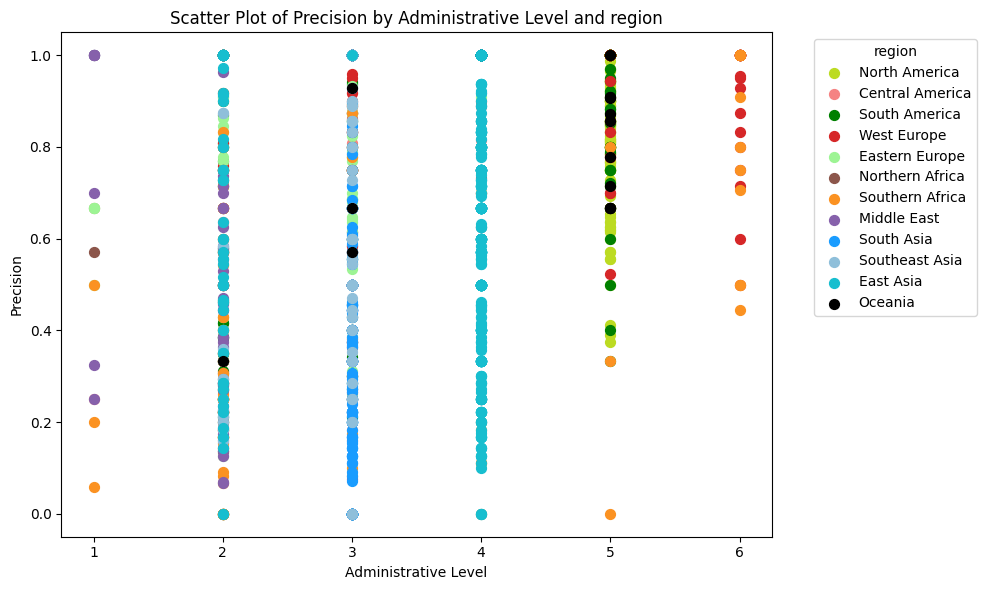

In [208]:
##########################################
# 凡例を作る
##########################################
# カラーマッピング
colors = {
    'North America': '#bcdb22',
    'Central America': '#f58383',
    'South America': '#008000',
    'West Europe': '#d62728',
    'Eastern Europe': '#9df494',
    'Northern Africa': '#8c564b',
    'Southern Africa': '#fb9222',
    'Middle East': '#8661ab',
    'South Asia': '#199cff',
    'Southeast Asia': '#8fbfda',
    'East Asia': '#17becf',
    'Oceania': '#000000'
}

# ラベル順を指定
label_order = [
    'North America', 'Central America', 'South America', 
    'West Europe', 'Eastern Europe',
    'Northern Africa', 'Southern Africa',
    'Middle East',
    'South Asia', 'Southeast Asia', 'East Asia',
    'Oceania',
]

# 散布図の作成
plt.figure(figsize=(10, 6))

# 各 region ごとにプロット
for region in label_order:
    subset = city_table_data_revised[city_table_data_revised['region'] == region]
    if not subset.empty:
        plt.scatter(
            subset['Administrative Level'],  # 必要に応じて列名を調整
            subset['precision'],  # 必要に応じて列名を調整
            s=marker_size,  # サイズを固定値に設定
            color=colors.get(region, 'gray'),  # 指定された色、デフォルトは灰色
            label=region,
            alpha=1.0
        )

# 軸ラベルとタイトル
plt.xlabel('Administrative Level')
plt.ylabel('Precision')
plt.title('Scatter Plot of Precision by Administrative Level and region')

# 凡例の設定
plt.legend(title='region', bbox_to_anchor=(1.05, 1), loc='upper left')

# グラフのレイアウト調整
plt.grid(False)
plt.tight_layout()

# グラフを表示
plt.show()

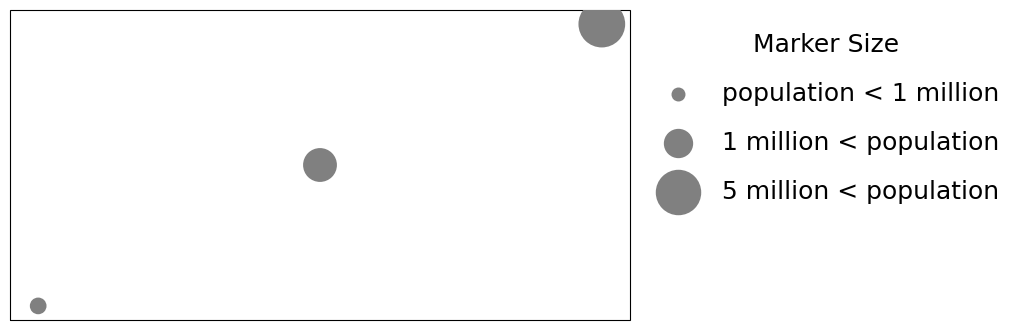

In [292]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# プロットするデータ
pprf_lon = [10, 20, 30]
pprf_lat = [50, 55, 60]
pop_size = [100, 500, 1000]  # マーカーサイズ

# figureのセットアップ
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# scatter plot
scatter = ax.scatter(
    pprf_lon, pprf_lat, s=pop_size,  
    color='grey', linewidths=2, transform=ccrs.PlateCarree(), zorder=3
)

# プロキシアーティストを作成 (凡例用)
sizes = [80, 400, 1000]
labels = ['population < 1 million', '1 million < population', '5 million < population']

# 凡例用の空のプロットを作成
for size, label in zip(sizes, labels):
    plt.scatter([], [], s=size, color='grey', linewidths=1.1, label=label)

# 凡例の設定
ax.legend(
    scatterpoints=1, frameon=False, labelspacing=1, title="Marker Size",
    loc='upper left', bbox_to_anchor=(1, 1)  # 図の右上に凡例を配置
)

# プロット表示
plt.show()
